##### Importing all libraries

In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
init_notebook_mode(connected=True)
RANDOM_SEED = 123

2024-05-23 13:55:22.856323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 13:55:22.856411: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 13:55:22.986056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Training / Testing Directories

In [2]:
TRAIN_DIR = ('/kaggle/input/facial-recognition-dataset/Training/Training')
TEST_DIR = ('/kaggle/input/facial-recognition-dataset/Testing/Testing')

Function to load the data

In [3]:
def load_data(dir_path, IMG_SIZE):

    X = []
    y = []
    i = 0
    labels = dict()
    for path in sorted(os.listdir(dir_path)):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):  # Using os.path.join() for path concatenation
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))  # Using os.path.join() for path concatenation
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [4]:
IMG_SIZE= (48, 48)

It took 11 minutes 20 seconds (CPU) or 8 minutes 41 seconds (GPU) to run this part and load all the images. (Timer is not necessary)

In [5]:
import time

start_time = time.time()

X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

28273 images loaded from /kaggle/input/facial-recognition-dataset/Training/Training directory.
Execution time: 216.73503494262695 seconds


In [6]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

Same here, timer is not necessary. Took 4 minutes 5 seconds using CPU and 2 minutes 31 seconds using GPU.

In [7]:
start_time = time.time()

X_test, y_test, test_labels = load_data(TEST_DIR, IMG_SIZE)

end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

7067 images loaded from /kaggle/input/facial-recognition-dataset/Testing/Testing directory.
Execution time: 43.237712144851685 seconds


Function to plot samples from each emotion category

In [8]:
def plot_samples(X, y, labels_dict, n=50):

    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

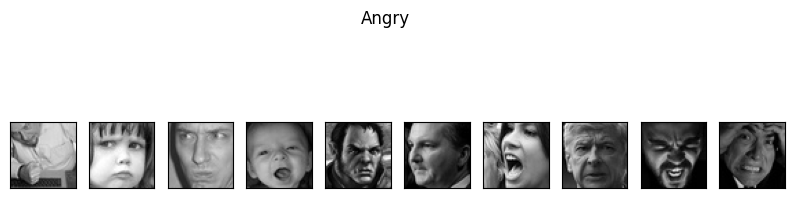

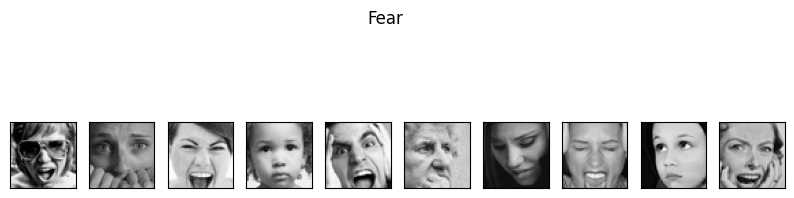

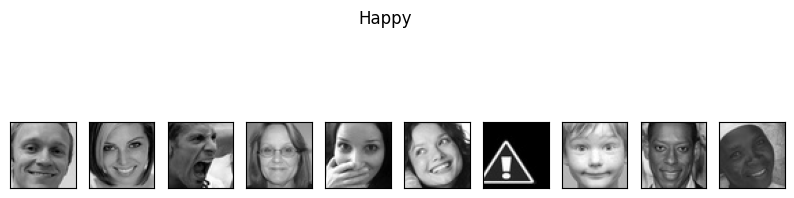

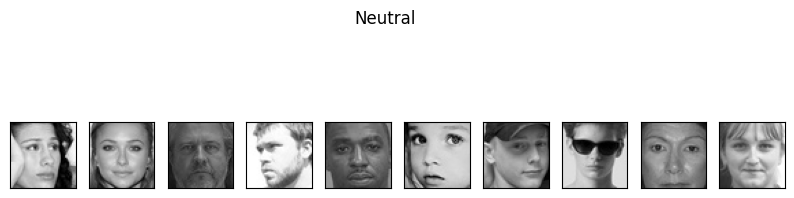

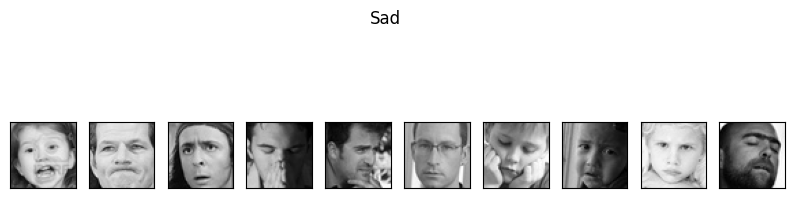

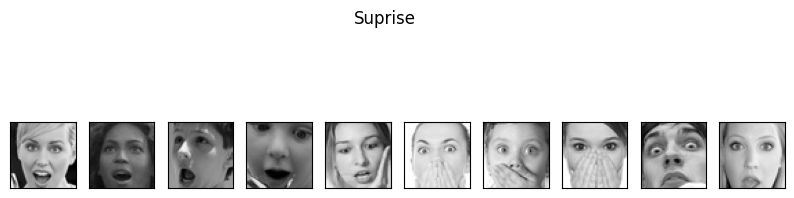

In [9]:
plot_samples(X_train, y_train, train_labels, 10)

In [10]:
from keras.utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_train.shape

(28273, 6)

In [11]:
Y_test = to_categorical(y_test, num_classes=6)
Y_test.shape

(7067, 6)

In [12]:
from keras.applications.vgg19 import VGG19

base_model = VGG19(
        weights=None,
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )

base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
NUM_CLASSES = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [14]:
from sklearn.model_selection import train_test_split

def deep_model(model, X_train, Y_train, epochs, batch_size):
    # Split the data
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=RANDOM_SEED)

    model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

    history = model.fit(X_train
                       , Y_train
                       , epochs=epochs
                       , batch_size=batch_size
                       , verbose=1
                       , validation_data=(X_val, Y_val))  # Add validation data here
    return history

The example I have based my work on used 500 epochs with batch size 128. The running time of that would probably take a couple of days using CPU. So I am using GPU for all experiments. I am running 20 epochs for my first example. With GPU it took 9 minutes 40 seconds to run 20 epochs. Second test, 100 epochs. It took 48 minutes 25 seconds to run 100 epochs on GPU. Last test, 500 epochs. Not possible on google colab. So I moved to Kaggle notebooks as Kaggle offers more GPU resources which can run all 500 epochs in the background.

In [15]:
epochs = 500
batch_size = 128

history = deep_model(model, X_train, Y_train, epochs, batch_size)

Epoch 1/500
  1/177 ━━━━━━━━━━━━━━━━━━━━ 1:15:19 26s/step - accuracy: 0.1484 - loss: 0.6931

I0000 00:00:1716472826.835115      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716472826.859304      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.2315 - loss: 0.5571

W0000 00:00:1716472863.050328      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716472864.525568      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


177/177 ━━━━━━━━━━━━━━━━━━━━ 67s 238ms/step - accuracy: 0.2316 - loss: 0.5568 - val_accuracy: 0.2500 - val_loss: 0.4653
Epoch 2/500
  1/177 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.2422 - loss: 0.4650

W0000 00:00:1716472868.801649      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.2582 - loss: 0.4508 - val_accuracy: 0.2500 - val_loss: 0.4450
Epoch 3/500
177/177 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - accuracy: 0.2586 - loss: 0.4441 - val_accuracy: 0.2500 - val_loss: 0.4448
Epoch 4/500
177/177 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.2556 - loss: 0.4442 - val_accuracy: 0.2500 - val_loss: 0.4448
Epoch 5/500
177/177 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.2559 - loss: 0.4443 - val_accuracy: 0.2500 - val_loss: 0.4445
Epoch 6/500
177/177 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - accuracy: 0.2561 - loss: 0.4440 - val_accuracy: 0.2500 - val_loss: 0.4448
Epoch 7/500
177/177 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.2536 - loss: 0.4444 - val_accuracy: 0.2500 - val_loss: 0.4447
Epoch 8/500
177/177 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.2539 - loss: 0.4443 - val_accuracy: 0.2500 - val_loss: 0.4450
Epoch 9/500
177/177 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.2593 - loss: 0.444

In [16]:
# #TEST TEST TEST AUGMENTATION AND EARLY STOPPAGE


# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping

# # Define your data augmentation
# datagen_train = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest')

# # Fit the augmentation to your training data
# datagen_train.fit(X_train)

# # Define early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# # Set your epochs and batch size
# epochs = 200  # Set a high number of epochs
# batch_size = 128

# # Modify your deep_model function to use the augmented data and early stopping
# def deep_model(model, X_train, Y_train, datagen, epochs, batch_size):
#     # Split the data
#     X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=RANDOM_SEED)

#     model.compile(
#     loss='binary_crossentropy',
#     optimizer=RMSprop(learning_rate=1e-4),
#     metrics=['accuracy'])

#     history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
#                        epochs=epochs,
#                        verbose=1,
#                        validation_data=(X_val, Y_val),
#                        callbacks=[early_stopping])  # Add early stopping here
#     return history

# # Call your deep_model function with the augmented data
# history = deep_model(model, X_train, Y_train, datagen_train, epochs, batch_size)

Function to plot the confusion matrix

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

 15/221 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

W0000 00:00:1716484735.134017      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


W0000 00:00:1716484741.029039      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Accuracy = 0.58


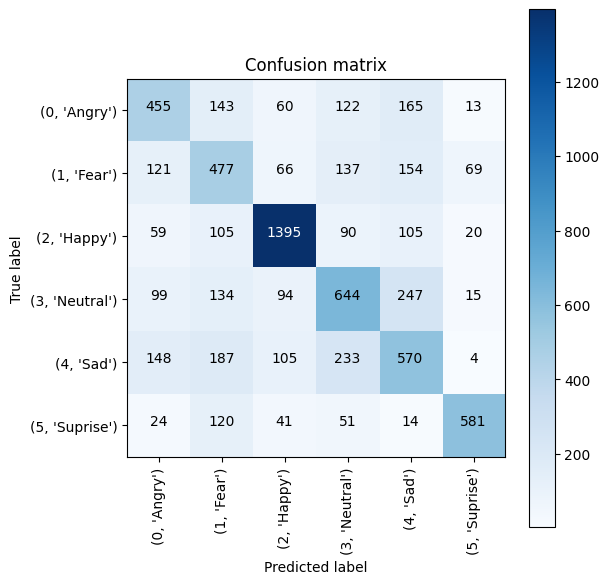

In [18]:
# Validate on test set

predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]


accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred)
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_test = ImageDataGenerator(rescale = 1./255)
pred_generator = datagen_test.flow_from_directory(TEST_DIR,
                                                 target_size = (48,48),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=False)

Found 7067 images belonging to 6 classes.


In [20]:
new_predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in new_predictions]
y_pred = [test_labels[k] for k in y_pred]

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


In [21]:
filenames = pred_generator.filenames
actual_class = [test_labels[h] for h in pred_generator.classes]

In [22]:
import pandas as pd

pred_result = pd.DataFrame({"Filename":filenames,
                           "Predictions":y_pred,
                           "Actual Values":actual_class})

pred_result.head()

,Filename,Predictions,Actual Values
0,Angry/Angry-1.jpg,Happy,Angry
1,Angry/Angry-10.jpg,Fear,Angry
2,Angry/Angry-100.jpg,Angry,Angry
3,Angry/Angry-101.jpg,Happy,Angry
4,Angry/Angry-102.jpg,Neutral,Angry


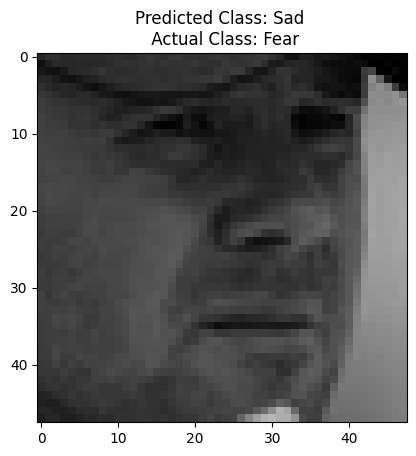

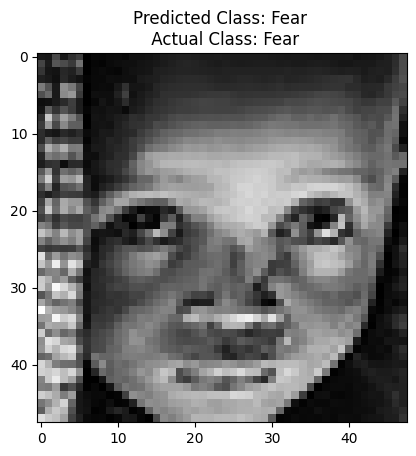

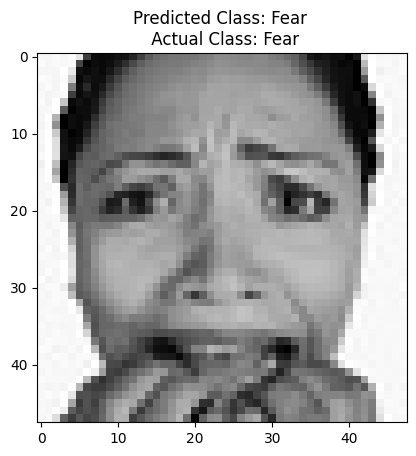

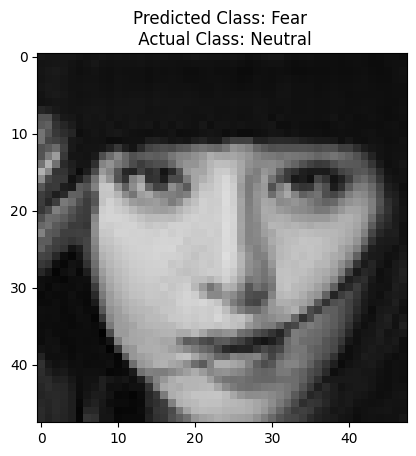

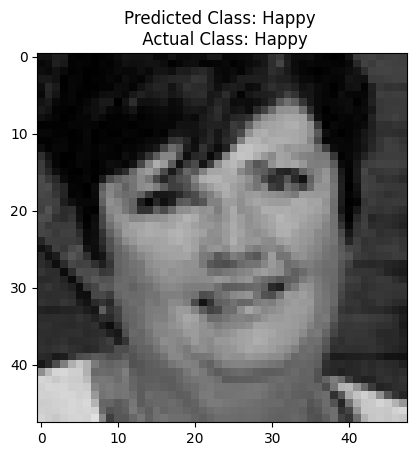

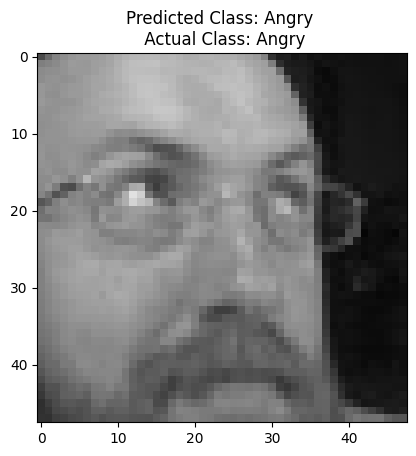

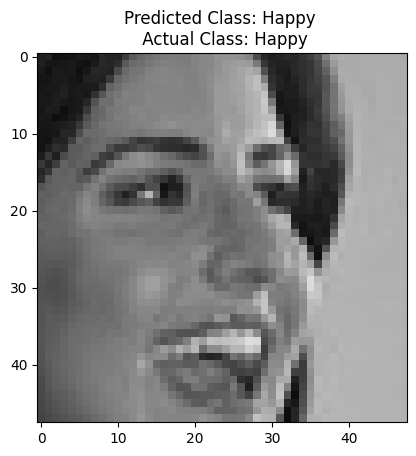

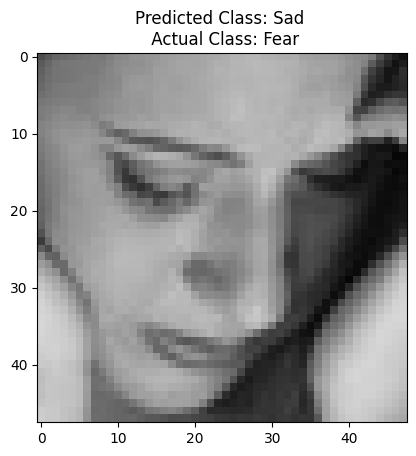

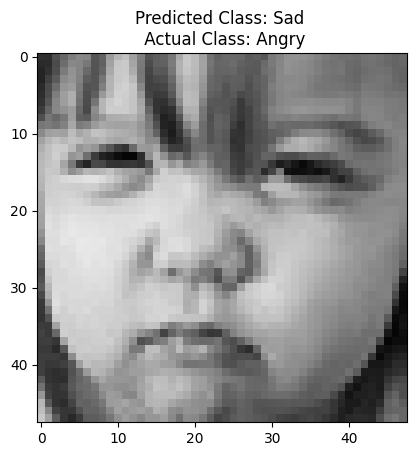

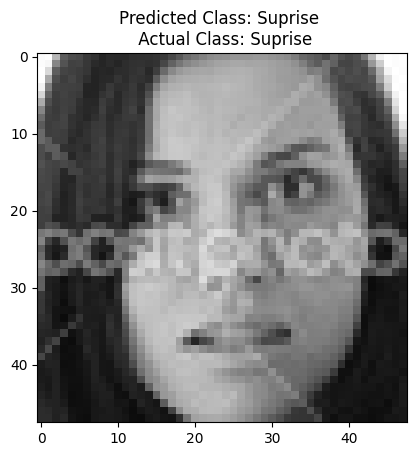

In [23]:
from random import randint

l = len(filenames)
base_path = TEST_DIR
for i in range(10):  # 10 images

    rnd_number = randint(0,l-1)
    filename,pred_class,actual_class = pred_result.loc[rnd_number]

    img_path = os.path.join(base_path,filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Predicted Class: {} {} Actual Class: {}".format(pred_class,'\n',actual_class))
    plt.show()
    pass

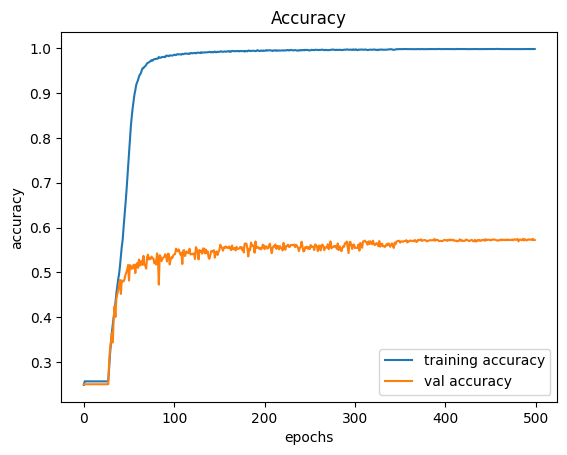

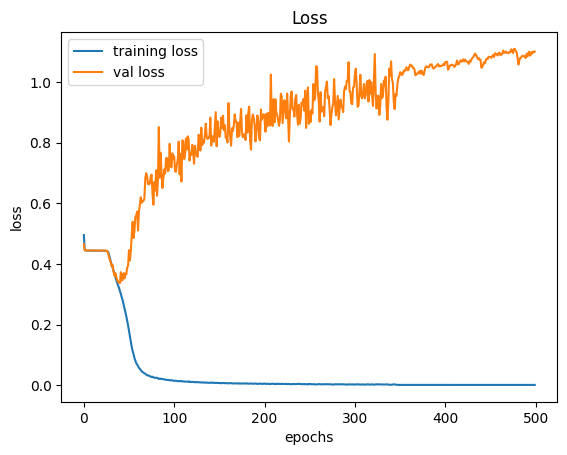

In [24]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title("Accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()